In [1]:
from qiskit import QuantumCircuit
# from qiskit_utils import algorithm_globals
from qiskit_algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import *
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import *
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Dims
rows = 2
cols = 2

#construct a matrix representation of vertices/tiles, matrix[row][col]
tile_matrix = np.zeros(shape=(rows,cols), dtype=int)
tile_mappings = dict()
tile_count = 0
for r in range(rows):
    for c in range(cols):
        tile_matrix[r,c] = tile_count
        tile_mappings[tile_count] = (r,c)
        tile_count += 1

print(tile_matrix)

def make_edge(u,v):
    return "e(%d,%d)" % (min(u,v), max(u,v))

#primitive: tuple (number, dir) i.e. 0d is for the downward edge on 0
#full edge: e(u,v) where u < v
#half edge: h(u,dir)
edge_mappings = dict()
#establish edges by trying to go up down left right in the matrix.
for r in range(rows):
    for c in range(cols):
        this_tile = tile_matrix[r,c] #id of tile at row r and column c
        #down edge (r+1)
        if (r == rows - 1): #cannot make a down edge because no tiles to its down
            edge_mappings["h(%d,%s)" % (tile_matrix[r,c],'d')] = [(tile_matrix[r,c], 'd')]
        else:
            e_down = make_edge(this_tile, tile_matrix[r+1,c])
            if (e_down not in edge_mappings):
                edge_mappings[e_down] = [(this_tile, 'd'), (tile_matrix[r+1,c], 'u')]
        
        #up edge (r-1)
        if (r == 0): #cannot make an up edge because no tiles to its up
            edge_mappings["h(%d,%s)" % (tile_matrix[r,c],'u')] = [(tile_matrix[r,c], 'u')]
        # else: 
        #     e_up = make_edge(this_tile, tile_matrix[r-1,c])
        #     if (e_up not in edge_mappings):
        #         edge_mappings[e_up] = [(this_tile, 'u'), (tile_matrix[r-1,c], 'd')]

        #right edge (c+1)
        if (c == cols - 1):
            edge_mappings["h(%d,%s)" % (tile_matrix[r,c],'r')] = [(tile_matrix[r,c], 'r')]
        else: 
            e_right = make_edge(this_tile, tile_matrix[r,c+1])
            if (e_right not in edge_mappings):
                edge_mappings[e_right] = [(this_tile, 'r'), (tile_matrix[r,c+1], 'l')]

        if (c == 0):
            edge_mappings["h(%d,%s)" % (tile_matrix[r,c],'l')] = [(tile_matrix[r,c], 'l')]
# print(edge_mappings)

#mapping primitive i.e. (0,'d') to an edge i.e. (0,2)
h_mappings = dict()

for key in edge_mappings:
    for prim in edge_mappings[key]:
        h_mappings[prim] = key

# Create a QUBO
qubo = QuadraticProgram()

# x[row][col][type]
# types: 0 -> empty, 1 -> horizontal, 2 -> vertical

for e in edge_mappings:
    qubo.binary_var(e)

# qubo.minimize(linear=[1,1,1,1,1,1,1,1], quadratic={})
qubo.minimize(linear = [1] * len(edge_mappings), quadratic={})

# qubo.linear_constraint(linear={"up":2,"left":1,"down":-2,"right":-1}, sense="==", rhs=0)

for r in range(rows):
    for c in range(cols):
        this_tile = tile_matrix[r,c]
        edge_u = h_mappings[(this_tile, 'u')]
        edge_d = h_mappings[(this_tile, 'd')]
        edge_l = h_mappings[(this_tile, 'l')]
        edge_r = h_mappings[(this_tile, 'r')]
        qubo.linear_constraint(linear={edge_u:2, edge_l:1, edge_d:-2, edge_r:-1}, sense="==", rhs=0)

print(qubo.prettyprint())

[[0 1]
 [2 3]]
Problem name: 

Minimize
  e(0,1) + e(0,2) + e(1,3) + e(2,3) + h(0,l) + h(0,u) + h(1,r) + h(1,u) + h(2,d)
  + h(2,l) + h(3,d) + h(3,r)

Subject to
  Linear constraints (4)
    -e(0,1) - 2*e(0,2) + h(0,l) + 2*h(0,u) == 0  'c0'
    e(0,1) - 2*e(1,3) - h(1,r) + 2*h(1,u) == 0  'c1'
    2*e(0,2) - e(2,3) - 2*h(2,d) + h(2,l) == 0  'c2'
    2*e(1,3) + e(2,3) - 2*h(3,d) - h(3,r) == 0  'c3'

  Binary variables (12)
    e(0,2) h(0,u) e(0,1) h(0,l) e(1,3) h(1,u) h(1,r) h(2,d) e(2,3) h(2,l) h(3,d)
    h(3,r)



In [3]:
converter = QuadraticProgramToQubo()
qubo_with_penalty = converter.convert(qubo)
op, offset = qubo_with_penalty.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: 136.0
operator:
SparsePauliOp(['IIIIIIIIIIIZ', 'IIIIIIIIIIZI', 'IIIIIIIIIZII', 'IIIIIIIIZIII', 'IIIIIIIZIIII', 'IIIIIIZIIIII', 'IIIIIZIIIIII', 'IIIIZIIIIIII', 'IIIZIIIIIIII', 'IIZIIIIIIIII', 'IZIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIIIIIZZ', 'IIIIIIIIIZIZ', 'IIIIIIIIIZZI', 'IIIIIIIIZIIZ', 'IIIIIIIIZIZI', 'IIIIIIIIZZII', 'IIIIIIIZIZII', 'IIIIIIZIIZII', 'IIIIIIZZIIII', 'IIIIIZIIIZII', 'IIIIIZIZIIII', 'IIIIIZZIIIII', 'IIIIZIIIIIIZ', 'IIIZIIIIIIIZ', 'IIIZIIIZIIII', 'IIIZZIIIIIII', 'IIZIIIIIIIIZ', 'IIZIZIIIIIII', 'IIZZIIIIIIII', 'IZIIIIIZIIII', 'IZIZIIIIIIII', 'ZIIIIIIZIIII', 'ZIIZIIIIIIII', 'ZZIIIIIIIIII'],
              coeffs=[ -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,
  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,
 -26. +0.j,  13. +0.j, -13. +0.j, -13. +0.j,  13. +0.j,  -6.5+0.j,
 -13. +0.j,  13. +0.j, -26. +0.j,  -6.5+0.j,  13. +0.j, -13. +0.j,
 -26. +0.j, -13. +0.j,  13. +0.j,  13. +0.j,  13. +0.j, -13. +0.j,
  -6.5+0.j, -26. +0.j, -13. 

In [4]:
qaoa_mes = QAOA(sampler=Sampler(options={"shots":1000000}), optimizer=COBYLA())
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

objective function value: 0.0
variable values: e(0,2)=0.0, h(0,u)=0.0, e(0,1)=0.0, h(0,l)=0.0, e(1,3)=0.0, h(1,u)=0.0, h(1,r)=0.0, h(2,d)=0.0, e(2,3)=0.0, h(2,l)=0.0, h(3,d)=0.0, h(3,r)=0.0
status: SUCCESS


In [5]:
print("variable order:", [var.name for var in qaoa_result.variables])

print(len(qaoa_result.samples))

for s in qaoa_result.samples:
    if (s.status==OptimizationResultStatus.SUCCESS):
        print(s)

variable order: ['e(0,2)', 'h(0,u)', 'e(0,1)', 'h(0,l)', 'e(1,3)', 'h(1,u)', 'h(1,r)', 'h(2,d)', 'e(2,3)', 'h(2,l)', 'h(3,d)', 'h(3,r)']
3796
SolutionSample(x=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=0.0, probability=0.00031, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.]), fval=3.0, probability=0.001659, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), fval=3.0, probability=2.4e-05, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.]), fval=3.0, probability=2.3e-05, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.]), fval=3.0, probability=0.001634, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.]), fval=6.0, probability=0.000

In [6]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res
filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.001, allowed_status=(OptimizationResultStatus.SUCCESS,)
)
for s in filtered_samples:
    print(s)

print(s)

SolutionSample(x=array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.]), fval=3.0, probability=0.001659, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.]), fval=3.0, probability=0.001634, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.]), fval=6.0, probability=0.003766, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.]), fval=6.0, probability=0.003766, status=<OptimizationResultStatus.SUCCESS: 0>)


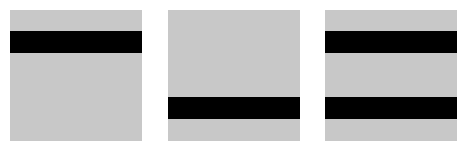

In [7]:
height, width, channel = 3 * rows, 3 * cols, 3

figcols = 20 // cols
figrows = len(filtered_samples) // figcols + 1
fig = plt.figure(figsize=(20, figrows * 2)) 


def paint(tile_mappings, h):
    tile, dir = h
    r, c = tile_mappings[tile]
    center = (r * 3 + 1, c * 3 + 1) #center of the (r,c) tile on the canvas
    dir_modifier = None
    if dir == 'u':
        dir_modifier = (-1,0)
    if dir == 'd':
        dir_modifier = (1,0)
    if dir == 'l':
        dir_modifier = (0,-1)
    if dir == 'r':
        dir_modifier = (0,1)
    draw_tile_dir = (center[0] + dir_modifier[0], center[1] + dir_modifier[1])
    return [center, draw_tile_dir]

for s in range(len(filtered_samples)):
    arr = np.full((height, width, channel), [200, 200, 200], dtype=('uint8'))
    draw_target = filtered_samples[s]
    for i, v in enumerate(draw_target.x):
        if int(v) == 1:
            e = qaoa_result.variables[i].name
            prims = edge_mappings[e]
            for p in prims:
                paint_tiles = paint(tile_mappings, p)
                for t in paint_tiles:
                    for chan in range(3):
                        arr[t[0], t[1], chan] = 0
    fig.add_subplot(figrows, figcols, s + 1)
    plt.imshow(arr)
    plt.axis('off')

Sample with probability 0.001659
Variables with value 1:
e(0,1)
h(0,l)
h(1,r)
Sample with probability 0.001634
Variables with value 1:
e(2,3)
h(2,l)
h(3,r)
Sample with probability 0.003766
Variables with value 1:
e(0,1)
h(0,l)
h(1,r)
e(2,3)
h(2,l)
h(3,r)


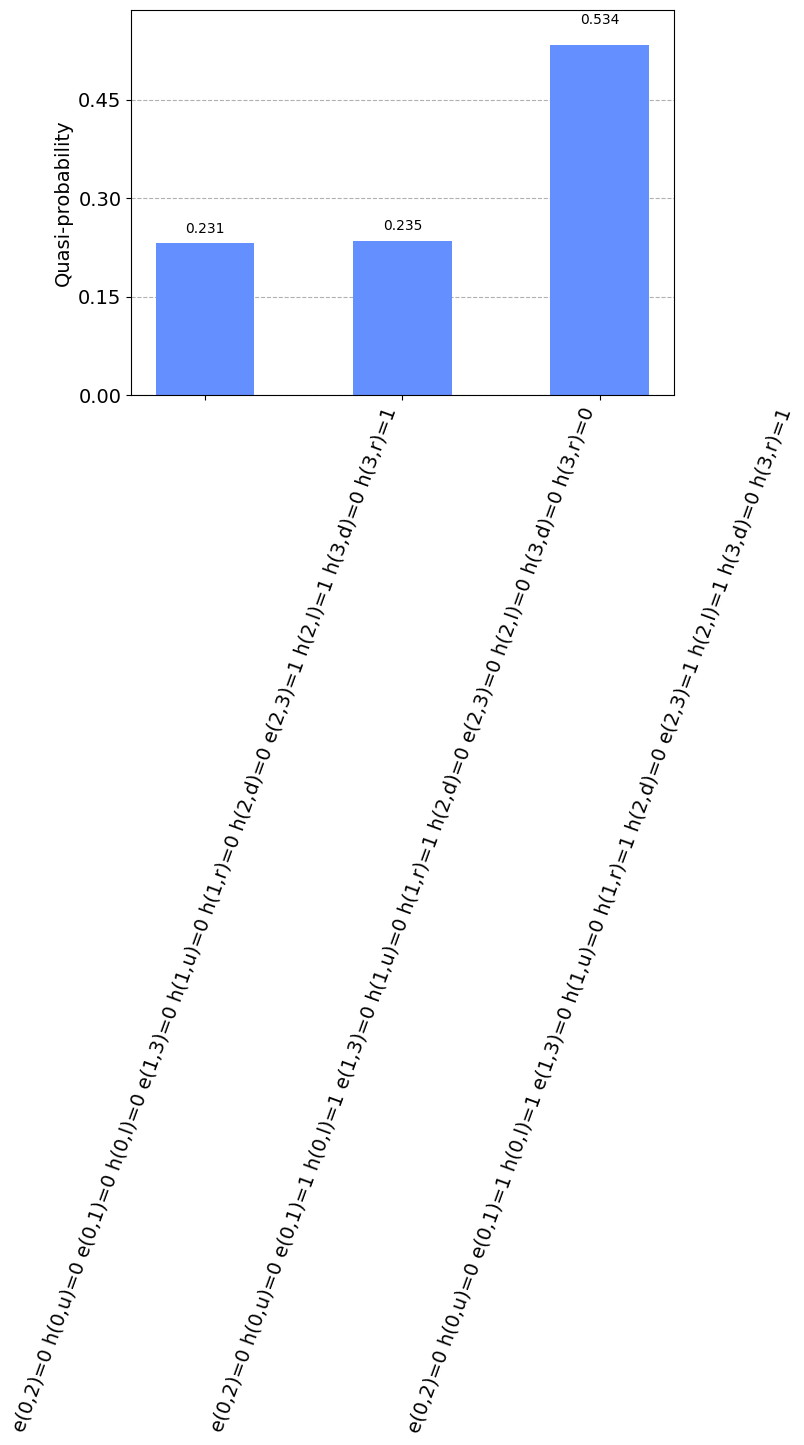

In [8]:
samples_for_plot = {}

for s in filtered_samples:
    sample_str = " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))

    samples_for_plot[sample_str] = s.probability

    print("Sample with probability", s.probability)
    print("Variables with value 1:")
    for i, v in enumerate(s.x):
        if int(v) == 1:
            print(qaoa_result.variables[i].name)

plot_histogram(samples_for_plot)
